# Trabajo Práctico: Predicción de lluvia en Australia.

**Materia:** Aprendizaje Automático I (IA41)

**Comisión:** C-31527

**Año académico:** 2024

**Período lectivo:** 1° cuatrimestre

**Integrantes:**
- Moresco Brisa
- Britos Julián Francisco

# To Do List

- Realizar la imputación de nulos previo a dividir el set de datos en train y test, ¿creen que es la mejor opción? Podría generarse data leakage.

- En cuanto a la forma de hacer el split del set de datos, ¿creen que es la correcta para evitar data leakage? Se trata de un conjunto con fuerte dependencia cronológica.

- ¿Está el set de datos balanceado o no?

- Resta completar el análisis estadístico descriptivo con gráficos, comentarios y conclusiones.

- Es importante agregar una gráfica de pérdida vs. iteraciones del gradiente descendente para observar que el modelo converja.

- En cuanto al cálculo de métricas, restan las correspondientes al set de entrenamiento. ¿Por qué ambas son necesarias?

- ¿Consiguió un buen fitting?

- ¿Conclusiones?

# Librerías

In [20]:
#!pip install pandas
#!pip install seaborn
#!pip install -U scikit-learn
#!pip install numpy

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, SGDRegressor, ElasticNet, ElasticNetCV, LassoCV, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Carga de datos

In [22]:
# Carga datos de dataset
# Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
# tras observar los datos del día de hoy, el objetivo es predecir las variables target:
#                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
#                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
weather_data = pd.read_csv(file_path, sep=',',engine='python')

# Análisis estadístico descriptivo

## Visualización de datos

In [23]:
# Vista de datos
weather_data

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145407,145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,0.0
145408,145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,0.0
145409,145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,0.0
145410,145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,0.0


In [24]:
# Columnas
weather_data.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [25]:
# Tipos de variables
weather_data.dtypes

Unnamed: 0            int64
Date                 object
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object

In [26]:
# Cantidad de valores faltantes.
weather_data.isna().sum()

Unnamed: 0              0
Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

In [27]:
# Estadísticas descriptivas
weather_data.describe(include='all')

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,145412.000000,145412,145412,143928.000000,144159.000000,142152.000000,82658.000000,75616.000000,135096,135159.000000,...,140907.000000,130351.000000,130388.000000,89542.000000,86076.000000,143646.000000,141805.000000,142152,142153,142153.000000
unique,NaN,3435,49,NaN,NaN,NaN,NaN,NaN,16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN
top,NaN,2013-11-11,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN
freq,NaN,49,3435,NaN,NaN,NaN,NaN,NaN,9910,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110276,110281,NaN
mean,72728.184393,NaN,NaN,12.195873,23.223176,2.361516,5.468616,7.611241,NaN,40.036564,...,51.537432,1017.649277,1015.255184,4.447287,4.509770,16.992780,21.685249,NaN,NaN,2.361242
std,41990.722236,NaN,NaN,6.398018,7.118770,8.479338,4.193871,3.785612,NaN,13.607212,...,20.796720,7.107132,7.037981,2.887161,2.720306,6.488045,6.936358,NaN,NaN,8.479084
min,0.000000,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,...,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,NaN,NaN,0.000000
25%,36362.750000,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,...,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,NaN,NaN,0.000000
50%,72727.500000,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,...,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,NaN,NaN,0.000000
75%,109093.250000,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,...,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,NaN,NaN,0.800000


## Gráficos

### Datos de color

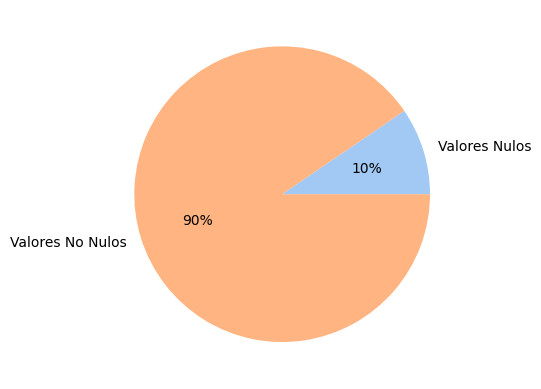

In [28]:
# Calcula el número total de valores (nulos y no nulos)
total_valores = np.product(weather_data.shape)

# Calcula el número de valores nulos
valores_nulos = weather_data.isnull().sum().sum()

# Calcula el número de valores no nulos
valores_no_nulos = total_valores - valores_nulos

# Crea una lista con los valores para el gráfico
datos = [valores_nulos, valores_no_nulos]

# Crea una lista con las etiquetas para el gráfico
etiquetas = ['Valores Nulos', 'Valores No Nulos']

colors = sns.color_palette("pastel")

plt.pie(datos, labels=etiquetas, colors=colors, autopct='%.0f%%')
plt.show()

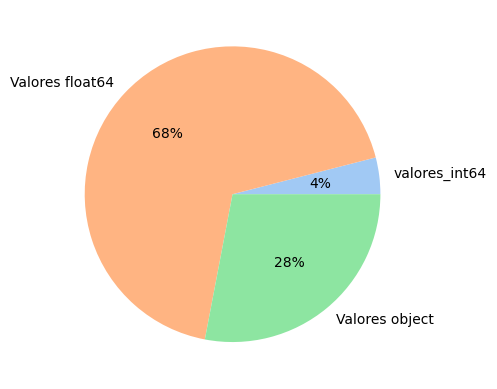

In [29]:
# Calcula el número de valores que son de tipo int64
valores_int64 = (weather_data.dtypes == 'int64').sum()

# Calcula el número de valores que son de tipo float64
valores_float64 = (weather_data.dtypes == 'float64').sum()

# Calcula el número de valores que son de tipo object
valores_object = (weather_data.dtypes == 'object').sum()

# Crea una lista con los valores para el gráfico
datos = [valores_int64, valores_float64, valores_object]

# Crea una lista con las etiquetas para el gráfico
etiquetas = ['valores_int64', 'Valores float64', 'Valores object']

colors = sns.color_palette("pastel")

plt.pie(datos, labels=etiquetas, colors=colors, autopct='%.0f%%')
plt.show()

### Location

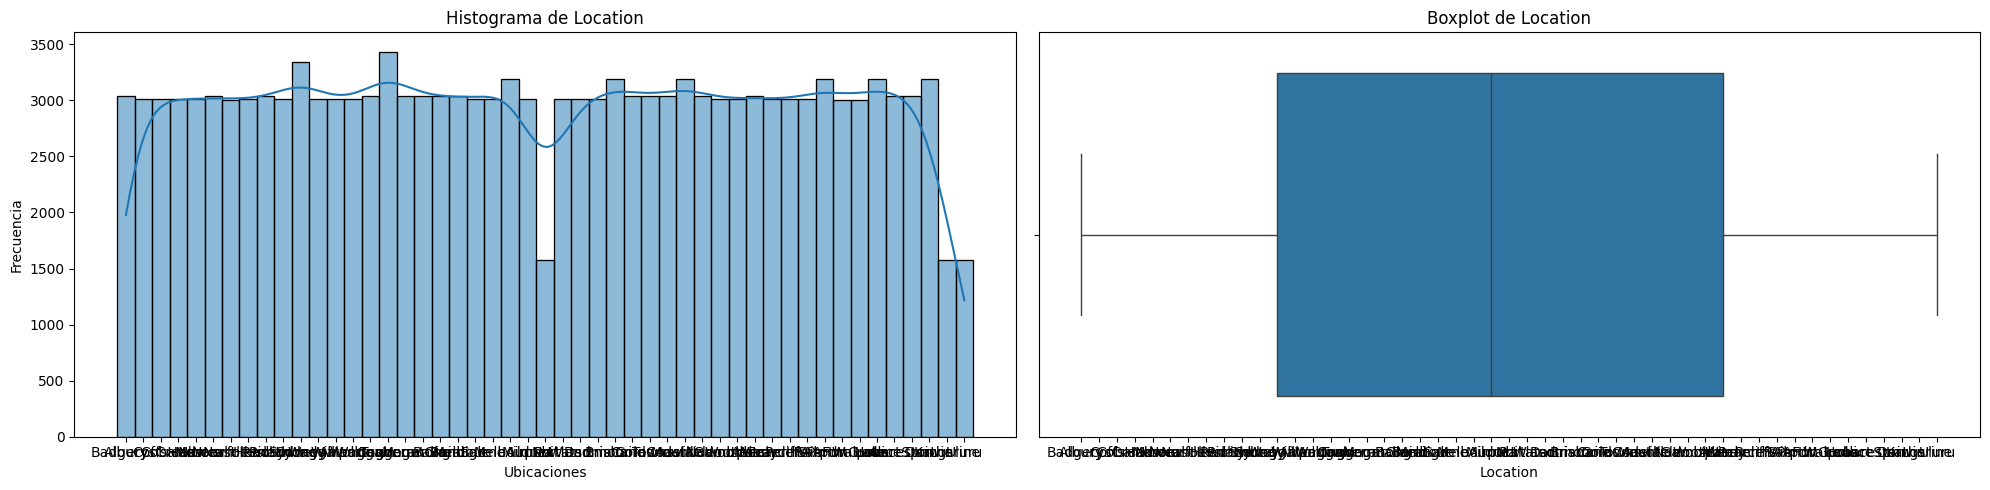

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Location'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Location')
axs[0].set_xlabel('Ubicaciones')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Location'], ax=axs[1])
axs[1].set_title('Boxplot de Location')

plt.tight_layout()
plt.show()


### MinTemp

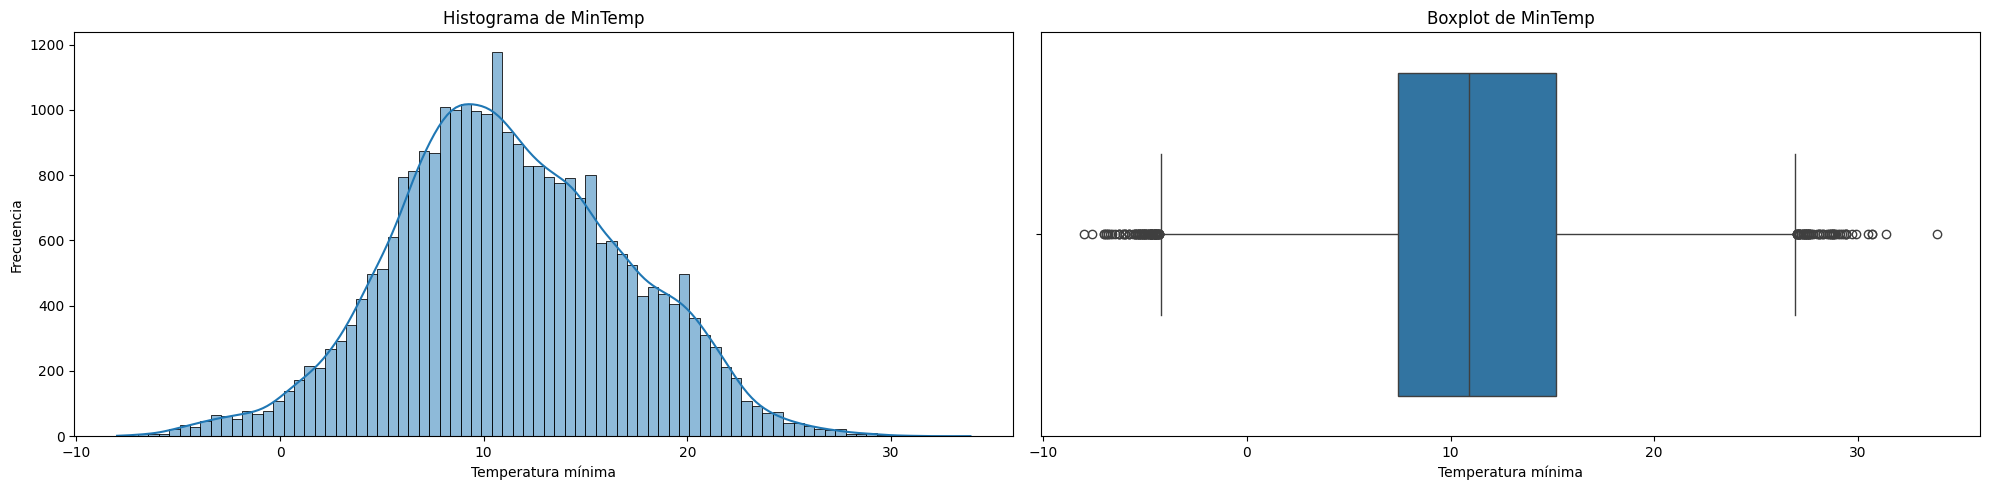

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['MinTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['MinTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


**Distribución de la temperatura mínima:** El histograma muestra la distribución de las temperaturas mínimas. La curva KDE (Kernel Density Estimate) sugiere una estimación suave de esta distribución. Parece que la mayoría de las temperaturas mínimas se agrupan alrededor de un rango específico, lo que indica una distribución con una tendencia central.

**Resumen estadístico de la temperatura mínima:** El boxplot proporciona un resumen estadístico de los datos de temperatura mínima. Muestra la mediana, los cuartiles y no se observan valores atípicos más allá de los bigotes del boxplot. Esto sugiere que los datos de temperatura mínima **no tienen valores extremos significativos**.

### MaxTemp

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['MaxTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MaxTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['MaxTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MaxTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


**Distribución de la temperatura máxima:** El histograma muestra la distribución de las temperaturas máximas. La curva KDE (Kernel Density Estimate) sugiere una estimación suave de esta distribución. Parece que la mayoría de las temperaturas máximas se agrupan alrededor de un rango específico, lo que indica una distribución con una tendencia central.

**Resumen estadístico de la temperatura máxima:** El boxplot proporciona un resumen estadístico de los datos de temperatura máxima. Muestra la mediana, los cuartiles y no se observan valores atípicos más allá de los bigotes del boxplot. Esto sugiere que los datos de temperatura máxima no tienen valores extremos significativos.

### Rainfall

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### Evaporation

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### Sunshine

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### WindGustDir

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### WindGustSpeed

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### WindDir9am

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### WindDir3pm

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### WindSpeed9am

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### WindSpeed3pm

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### Humidity9am

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### Humidity3pm

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### Pressure9am

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### Pressure3pm

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### Cloud9am

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### Cloud3pm

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### Temp9am

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### Temp3pm

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['Rainfall'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de Rainfall')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['Rainfall'], ax=axs[1])
axs[1].set_title('Boxplot de Rainfall')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()

### RainToday

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['MinTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['MinTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### RainTomorrow

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['MinTemp'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de MinTemp')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['MinTemp'], ax=axs[1])
axs[1].set_title('Boxplot de MinTemp')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()


### RainfallTomorrow

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Histograma
sns.histplot(weather_data['RainfallTomorrow'], kde=True, ax=axs[0])
axs[0].set_title('Histograma de RainfallTomorrow')
axs[0].set_xlabel('Temperatura mínima')
axs[0].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=weather_data['RainfallTomorrow'], ax=axs[1])
axs[1].set_title('Boxplot de RainfallTomorrow')
axs[1].set_xlabel('Temperatura mínima')

plt.tight_layout()
plt.show()

## Conclusiones 

# Reducción de dimensionalidad

Eliminamos las localidades que no nos interesan predecir

In [9]:
# Lista de ubicaciones deseadas
ubicaciones_deseadas = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Filtra el DataFrame para que solo contenga las ubicaciones deseadas
weather_data = weather_data[weather_data['Location'].isin(ubicaciones_deseadas)]

Eliminamos las siguientes columnas:
- Location: eliminamos esta columna, ya que vamos a tomar las ubicaciones:
'Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' como la si fueran una misma y así simplificar el modelo
- Unnamed: 0: Eliminamos esta columna, ya que no aporta nada de información al modelo


In [10]:
weather_data = weather_data.drop(['Unnamed: 0', 'Date', 'Location'], axis=1)

weather_data

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,6.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,NaN,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,30.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,6.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102515,6.2,16.3,0.0,NaN,NaN,N,41.0,N,NW,24.0,...,70.0,1026.3,1024.1,NaN,NaN,8.7,15.5,No,Yes,2.0
102516,8.7,13.2,2.0,NaN,NaN,S,20.0,NaN,SE,0.0,...,82.0,1029.2,1028.3,NaN,8.0,11.1,12.0,Yes,No,0.0
102517,7.0,15.7,0.0,NaN,NaN,N,31.0,N,NNW,13.0,...,67.0,1027.0,1022.4,8.0,NaN,10.0,14.9,No,No,0.0
102518,5.4,16.2,0.0,NaN,NaN,N,37.0,NNW,W,24.0,...,70.0,1017.0,1014.4,8.0,4.0,6.4,14.9,No,Yes,2.2


# Train y Test

In [11]:
# Dividir los datos en conjuntos de entrenamiento y prueba 
train, test = train_test_split(weather_data, test_size=0.2)

In [12]:
test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
99048,7.8,25.6,0.0,NaN,NaN,W,24.0,NE,WNW,11.0,...,32.0,1018.7,1015.3,NaN,NaN,19.2,24.1,No,No,0.0
66236,8.5,21.6,4.8,2.6,12.5,WSW,52.0,WSW,W,26.0,...,30.0,1018.8,1018.7,6.0,5.0,14.2,19.7,Yes,No,0.0
8323,11.6,14.4,8.6,1.2,NaN,W,33.0,NE,WSW,9.0,...,87.0,1021.3,1019.4,8.0,7.0,11.6,13.5,Yes,Yes,5.0
35780,11.0,17.4,1.4,1.0,0.8,SW,43.0,W,SE,13.0,...,83.0,1014.2,1013.6,7.0,7.0,14.4,15.3,Yes,Yes,62.8
48532,13.4,33.9,0.0,NaN,NaN,NNE,30.0,S,ENE,7.0,...,12.0,1022.3,1019.0,NaN,NaN,20.2,33.5,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83503,14.4,26.5,0.0,6.4,8.2,SE,33.0,S,SE,9.0,...,48.0,1020.2,1019.5,NaN,NaN,17.2,25.3,No,No,0.0
7734,10.0,25.2,0.0,8.4,NaN,WSW,44.0,SW,SW,13.0,...,21.0,1014.2,1012.4,1.0,2.0,15.2,23.4,No,No,0.0
47420,16.1,34.9,0.0,7.0,NaN,NaN,NaN,SE,NNE,6.0,...,25.0,1014.7,1009.0,8.0,1.0,20.4,31.9,No,No,0.0
33999,15.1,22.5,0.0,3.8,5.9,W,65.0,NW,WSW,11.0,...,36.0,1012.7,1011.7,6.0,2.0,18.8,18.2,No,Yes,3.8


In [13]:
train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
8743,9.0,22.1,0.0,3.4,NaN,NNE,33.0,NNE,ENE,19.0,...,29.0,1026.3,1022.6,NaN,NaN,15.6,21.8,No,No,0.0
64764,3.0,13.4,0.6,2.6,8.0,N,43.0,NNW,NNE,15.0,...,53.0,1023.1,1019.4,6.0,7.0,7.5,12.8,No,No,0.0
7418,10.9,26.1,0.0,11.0,NaN,S,39.0,S,S,17.0,...,15.0,1016.7,1013.2,0.0,1.0,14.0,24.8,No,No,0.0
46846,-1.6,14.4,0.0,2.0,8.5,WNW,22.0,ESE,NNW,9.0,...,41.0,1021.1,1018.8,6.0,NaN,4.0,13.9,No,No,0.0
81376,15.5,36.2,0.0,7.2,12.5,ESE,33.0,SSW,SSW,13.0,...,36.0,1018.8,1017.1,NaN,NaN,20.5,34.5,No,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100662,5.3,21.0,0.0,1.2,7.7,S,31.0,NNE,S,11.0,...,43.0,1024.2,1022.2,7.0,7.0,13.0,19.8,No,No,0.0
45866,0.0,14.0,0.0,2.4,4.7,WNW,39.0,NNW,WNW,13.0,...,36.0,1027.3,1024.4,7.0,7.0,7.9,12.4,No,No,0.0
65652,5.6,17.8,0.0,4.0,9.4,SSE,44.0,SE,SSE,24.0,...,49.0,1023.3,1019.1,1.0,5.0,12.1,16.5,No,No,0.0
47120,10.1,31.3,0.0,6.5,9.6,ENE,24.0,SSE,WNW,7.0,...,17.0,1023.4,1019.4,1.0,NaN,18.3,30.0,No,No,0.0


# Datos faltantes

## Eliminación de datos faltantes 

Verificamos si existen filas que contengan solo valores nulos.

In [14]:
# Contamos el número total de filas que tengan todos sus valores como nulos en train
train_nulas = train.isnull().all(axis=1).sum()

train_nulas

1

Vemos que si tiene una fila donde todos sus valores son nulos, así que la eliminamos.

In [15]:
train = train.dropna(how='all')

Verificamos que se haya borrado correctamente y que no queden filas que contengan todos sus valores nulos.

In [16]:
# Contamos el número total de filas que tengan todos sus valores como nulos en train
train_nulas = train.isnull().all(axis=1).sum()

train_nulas

0

Hacemos lo mismo con el test

In [17]:
# Contamos el número total de filas que tengan todos sus valores como nulos en train
test_nulas = test.isnull().all(axis=1).sum()

test_nulas

0

Vemos que no tiene una fila donde todos sus valores son nulos, así que hace falta realizar ninguna acción.

## Separación de datos

Separamos el Dataframe según sean sus datos continuos o categóricos para un mejor tratamiento de los mismo.

### Separación de train

In [31]:
# Separa las columnas categóricas
train_categoricas = train.select_dtypes(include=['object'])

In [32]:
train_categoricas.dtypes

WindGustDir     object
WindDir9am      object
WindDir3pm      object
RainToday       object
RainTomorrow    object
dtype: object

In [33]:
# Separa las columnas continuas
train_continuas = train.select_dtypes(include=['float64', 'int64'])

In [34]:
train_continuas.dtypes

MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustSpeed       float64
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainfallTomorrow    float64
dtype: object

### Separación de test

In [35]:
# Separa las columnas categóricas
test_categoricas = test.select_dtypes(include=['object'])

In [36]:
test_categoricas.dtypes

WindGustDir     object
WindDir9am      object
WindDir3pm      object
RainToday       object
RainTomorrow    object
dtype: object

In [37]:
# Separa las columnas continuas
test_continuas = test.select_dtypes(include=['float64', 'int64'])

In [38]:
test_continuas.dtypes

MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustSpeed       float64
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainfallTomorrow    float64
dtype: object

## Completado de datos 

### Completado de train

Verificamos si existen valores faltantes

In [39]:
train_categoricas.isnull().sum()

WindGustDir     1299
WindDir9am      1330
WindDir3pm       351
RainToday        770
RainTomorrow     771
dtype: int64

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda.

In [45]:
for columna in train_categoricas.columns:
    train_categoricas[columna].fillna(train_categoricas[columna].mode()[0], inplace=True)

Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [46]:
train_categoricas.isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

Verificamos si existen valores numéricos faltantes.

In [47]:
train_continuas.isnull().sum()

MinTemp              444
MaxTemp              434
Rainfall             770
Evaporation         3482
Sunshine            5385
WindGustSpeed       1299
WindSpeed9am         287
WindSpeed3pm         277
Humidity9am          731
Humidity3pm          687
Pressure9am          666
Pressure3pm          654
Cloud9am            7516
Cloud3pm            7668
Temp9am              457
Temp3pm              447
RainfallTomorrow     771
dtype: int64

Rellenamos los datos faltantes con la mediana.

In [48]:
train_continuas = train_continuas.fillna(train_continuas.median())

Verificamos que se hayan rellenado los valores faltantes con la mediana correctamente y que no queden valores nulos.

In [49]:
train_continuas.isnull().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainfallTomorrow    0
dtype: int64

### Completado de test

Verificamos si existen valores categoricos faltantes.

In [40]:
test_categoricas.isnull().sum()

WindGustDir     345
WindDir9am      317
WindDir3pm       85
RainToday       215
RainTomorrow    213
dtype: int64

Vemos que si hay datos faltantes, por lo tanto, rellenamos los datos faltantes con la moda.

In [41]:
for columna in test_categoricas.columns:
    test_categoricas[columna].fillna(test_categoricas[columna].mode()[0], inplace=True)


Verificamos que se hayan rellenado los valores faltantes con la moda correctamente y que no queden valores nulos.

In [42]:
test_categoricas.isnull().sum()

WindGustDir     0
WindDir9am      0
WindDir3pm      0
RainToday       0
RainTomorrow    0
dtype: int64

Verificamos si existen valores numéricos faltantes.

In [43]:
test_continuas.isnull().sum()

MinTemp              125
MaxTemp              123
Rainfall             215
Evaporation          870
Sunshine            1327
WindGustSpeed        342
WindSpeed9am          70
WindSpeed3pm          62
Humidity9am          208
Humidity3pm          202
Pressure9am          172
Pressure3pm          174
Cloud9am            1850
Cloud3pm            1881
Temp9am              127
Temp3pm              128
RainfallTomorrow     213
dtype: int64

Rellenamos los datos faltantes con la mediana.

In [44]:
test_continuas = test_continuas.fillna(test_continuas.median())

Verificamos que se hayan rellenado los valores faltantes con la mediana correctamente y que no queden valores nulos.

In [ ]:
test_continuas.isnull().sum()

MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustSpeed       0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainfallTomorrow    0
dtype: int64

Seleccioné la mediana para rellenar los datos faltantes en mi dataframe de variables continuas porque la mediana es una medida de tendencia central que no se ve afectada por los valores extremos o atípicos. En mi conjunto de datos, había algunos valores que eran mucho más altos o bajos que el resto, y si hubiera usado la media para rellenar los datos faltantes, estos valores extremos habrían sesgado la media y distorsionado mis resultados. La mediana, al ser el valor medio de un conjunto de datos ordenado, proporciona una mejor representación del 'valor típico' en mi conjunto de datos, especialmente cuando hay valores atípicos.

En cuanto a mi dataframe de variables categóricas, seleccioné la moda para rellenar los datos faltantes porque la moda es la categoría que ocurre con más frecuencia en un conjunto de datos. Dado que las variables categóricas no son numéricas, medidas como la media y la mediana no tienen sentido en este contexto. Al rellenar los datos faltantes con la moda, estoy esencialmente asumiendo que la categoría más común es la más probable de ocurrir en los datos faltantes. Esto puede no ser siempre el caso, pero es una suposición razonable en ausencia de información adicional.

# Estandarización

In [ ]:
# Crear el estandarizador
scaler = StandardScaler()

# Ajustar y transformar los datos
columnas_continuas_escaladas = scaler.fit_transform(columnas_continuas)

# Convertir el resultado a un DataFrame
columnas_continuas_escaladas = pd.DataFrame(columnas_continuas_escaladas, columns=columnas_continuas.columns)

In [ ]:
columnas_continuas_escaladas

# One hot enconding (Dummies)

In [ ]:
columnas_categoricas

Al tener demasiadas variables categóricas en mi DataFrame, lo que hice fue simplificar la situación agrupándolas. Tenía una columna con direcciones de viento que incluía 16 categorías distintas como 'N', 'NNW', 'NNE', etc. Pero para mi análisis, no necesitaba tanta granularidad, así que decidí agrupar estas 16 categorías en solo 4: 'N', 'S', 'E' y 'W'.

Para hacer esto, creé un diccionario que mapeaba cada una de las 16 categorías a una de las 4 direcciones principales. Luego, utilicé la función map de pandas para aplicar este mapeo a mi columna. De esta manera, pude reducir la cantidad de categorías únicas en mi columna de 16 a solo 4, lo que simplificó mucho mi análisis

In [ ]:
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
columnas_categoricas['WindGustDir'] = columnas_categoricas['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
columnas_categoricas['WindDir9am'] = columnas_categoricas['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
columnas_categoricas['WindDir3pm'] = columnas_categoricas['WindDir3pm'].map(diccionario_invertido)

columnas_categoricas


Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.

In [ ]:
columnas_categoricas_encoded = pd.get_dummies(columnas_categoricas).astype('int64')

columnas_categoricas_encoded

Elimino las columnas RainTomorrow_No y RainToday_No, ya que son columnas redundantes porque son perfectamente inversas a RainTomorrow_Yes y RainTomorrow_Yes, es decir, si un día tiene un '1' en 'RainTomorrow_No', entonces tiene un '0' en 'RainTomorrow_Yes', y viceversa.

In [ ]:
columnas_categoricas_encoded = columnas_categoricas_encoded.drop(['RainTomorrow_No', 'RainToday_No'], axis=1)

columnas_categoricas_encoded

# Matriz de correlación

## Matriz de correlación numérica

In [ ]:
sns.set_theme(style="white")
# Compute the correlation matrix
corr = columnas_continuas.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True,annot=True ,linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

## Matriz de correlación categórica

In [ ]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = columnas_categoricas_encoded.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True,annot=True ,linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# Validación Cruzada K-Folds

# Regresión Lineal

In [ ]:

# Encuentra las filas con valores faltantes en el conjunto de validación
filas_con_nan_val = np.isnan(X_val).any(axis=1) | np.isnan(y_val)

# Elimina las filas correspondientes de X_val e y_val
X_val_cleaned = X_val[~filas_con_nan_val]
y_val_cleaned = y_val[~filas_con_nan_val]

# Instanciar el imputador
imputer = SimpleImputer(strategy='mean')

# Ajustar y transformar los datos de entrenamiento
X_train_imputed = imputer.fit_transform(X_val_cleaned)
y_train_imputed = y_val_cleaned  # No hay necesidad de imputar las etiquetas

# Transformar los datos de validación
X_val_imputed = imputer.transform(X_val_cleaned)

# Continuar con el entrenamiento del modelo y la evaluación en el conjunto de validación


In [ ]:
# Crea una instancia del modelo de regresión lineal
model = LinearRegression()
model.fit(X_train_imputed, y_train_imputed)


In [ ]:
y_pred_val = model.predict(X_val_imputed)


In [ ]:

coefficients = model.coef_
intercept = model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# MSE: Error Cuadratico Medio
mse = mean_squared_error(y_test, y_pred_val)

# R^2
r2 = r2_score(y_test, y_pred_val)

# MAE: Error Absoluto Medio
mae = mean_absolute_error(y_test, y_pred_val)

# RMSE: Raíz del Error Cuadrático Medio
rmse = np.sqrt(mean_squared_error(y_test, y_pred_val))

print(f"\nR^2: {r2}\n")
print(f"MSE(Error Cuadratico Medio): {mse}\n")
print(f"MAE(Error Absoluto Medio): {mae}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse}\n")

# Gradiente descendiente

In [ ]:
# Regresión lineal utilizando SGDRegressor
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
model_sgd.fit(X_train_imputed, y_train_imputed)

In [ ]:
y_pred_sgd = model_sgd.predict(X_val_imputed)

In [ ]:
# Coeficientes
coefficients_sgd = model_sgd.coef_
intercept_sgd = model_sgd.intercept_
print("Coefficients (SGD):", coefficients_sgd)
print("Intercept (SGD):", intercept_sgd)

# MSE: Error Cuadrático Medio
mse_sgd = mean_squared_error(y_test, y_pred_sgd)

# R^2
r2_sgd = r2_score(y_test, y_pred_sgd)

# MAE: Error Absoluto Medio
mae_sgd = mean_absolute_error(y_test, y_pred_sgd)

# RMSE: Raíz del Error Cuadrático Medio
rmse_sgd = np.sqrt(mse_sgd)

print(f"\nR^2 (SGD): {r2_sgd}\n")
print(f"MSE (SGD): {mse_sgd}\n")
print(f"MAE (SGD): {mae_sgd}\n")
print(f"RMSE (SGD): {rmse_sgd}\n")

# Lasso

In [ ]:
lasso = Lasso(alpha=0.1)

lasso.fit(X_train_imputed, y_train_imputed)

In [ ]:
print("\nCoeficientes del modelo Lasso:")
print(lasso.coef_)
print("Lasso Score df_train:", lasso.score(X_val_imputed, y_test))
print("Lasso Score df_test:", lasso.score(X_val_imputed, y_test))

# Ridge

In [ ]:
ridge = Ridge(alpha=0.1)

ridge.fit(X_train_imputed, y_train_imputed)

In [ ]:
print("\nCoeficientes del modelo Ridge:")
print(ridge.coef_)
print("Ridge Score df_train:", ridge.score(X_val_imputed, y_test))
print("Ridge Score df_test:", ridge.score(X_val_imputed, y_test))